# Model Training & Evaluation

In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import os
import sys

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [23]:
import pandas as pd

pd.set_option('display.max_columns', None)

# suppress debugging warnings
import warnings
warnings.filterwarnings('ignore')

In [24]:
FOLDS = 3

In [25]:
from IPython.display import display
import joblib

X_train, X_test, y_train, y_test = joblib.load('../data/processed/accepted_2007_to_2018Q4.pkl')

## Training

### Train the model

In [26]:
from src.model import create_model

model = create_model(eval_metric='logloss')

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Inference
### Make predictions

In [27]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

## Evaluation

### Accuracy

In [28]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8782


### Classification Report

In [29]:
# Classification report
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89    197997
           1       0.97      0.78      0.87    198365

    accuracy                           0.88    396362
   macro avg       0.89      0.88      0.88    396362
weighted avg       0.89      0.88      0.88    396362



### Confusion Matrix

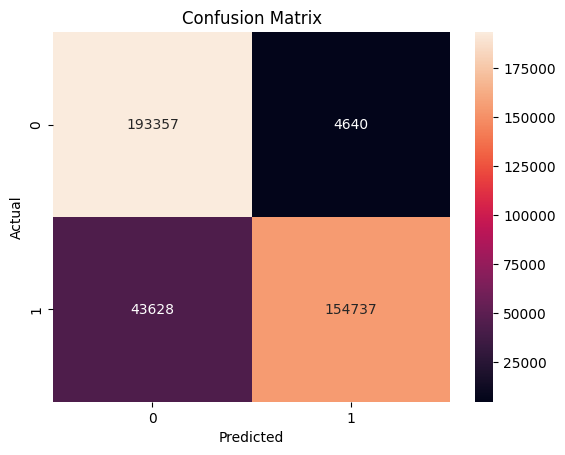

In [30]:
# Confusion matrix
from src import visualize

visualize.confusion_matrix(y_test, y_pred)

### ROC Curve

ROC-AUC Score: 0.9328


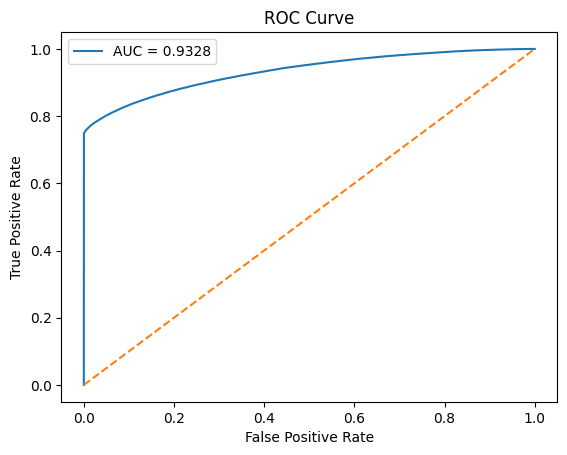

In [31]:
from sklearn.metrics import roc_auc_score

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
visualize.roc_curve(y_test, y_proba, roc_auc)

### Cross-Validation

In [32]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross Validation ROC-AUC Scores:")
print(f"Mean: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.2e}")

Cross Validation ROC-AUC Scores:
Mean: 0.9319
Standard deviation: 4.62e-04


## Feature importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(
    model, X_train, y_train, n_repeats=FOLDS, random_state=42)

# Get importance values
importances = result['importances_mean']

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

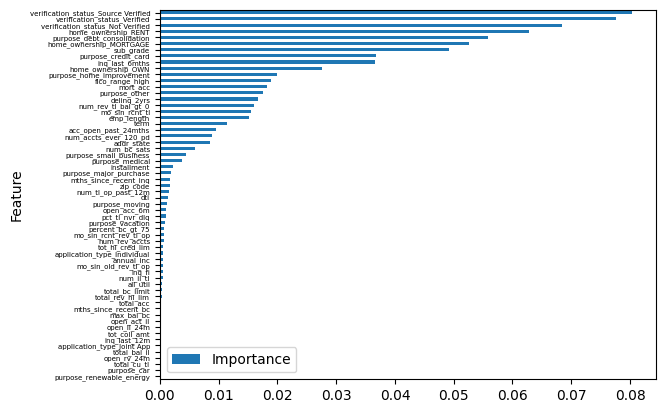

In [45]:
# Plot the feature importances
import matplotlib.pyplot as plt

ax = feature_importances.plot.barh(x='Feature', y='Importance')
ax.invert_yaxis()
for label in ax.get_yticklabels():
    label.set_fontsize(5)
plt.show()

## Hyperparameter Tuning

### Random search

In [34]:
import random

from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Takes 14.5min at 30 iterations
param_dist = {
    "max_depth": stats.randint(2, 3),
    "learning_rate": stats.uniform(loc=0.93, scale=0.07),
    "n_estimators": stats.randint(100, 1000),
    "subsample": stats.norm(0.85, scale=0.05),
    "colsample_bytree": stats.uniform(loc=0.98, scale=0.02),
}

# Setup the randomized search
search = RandomizedSearchCV(
    estimator=create_model(eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=30, # ~28sec/iter
    cv=FOLDS,
    verbose=0,
    random_state=42,
    n_jobs=(-1)
)

# Fit the model
search.fit(X_train, y_train)

# Best Model
print("Best Parameters:", search.best_params_)
print(f"Best ROC-AUC Score: {search.best_score_:.8f}")

Best Parameters: {'colsample_bytree': 0.9889166550570718, 'learning_rate': 0.9369982441072603, 'max_depth': 2, 'n_estimators': 558, 'subsample': 0.9184225061632877}
Best ROC-AUC Score: 0.87829308


### Retrain with these hyperparameters

In [35]:
best_params = search.best_params_
model_best = create_model(**best_params)
model_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9889166550570718, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9369982441072603,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=558, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluate the optimized model

In [36]:
# Predict on test data
y_pred_best = model_best.predict(X_test)
y_proba_best = model_best.predict_proba(X_test)[:,1]

# Accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Optimized Accuracy: {accuracy_best:.4f}")

print("Optimized Classification Report:\n", classification_report(y_test, y_pred_best))

Optimized Accuracy: 0.8787
Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89    197997
           1       0.97      0.78      0.87    198365

    accuracy                           0.88    396362
   macro avg       0.89      0.88      0.88    396362
weighted avg       0.89      0.88      0.88    396362



Optimized ROC-AUC Score: 0.9335


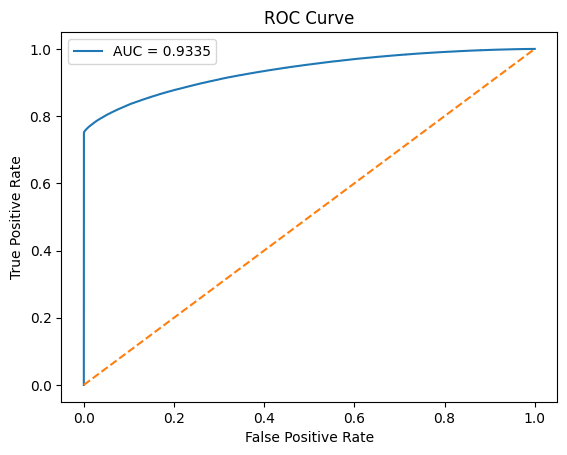

In [37]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba_best)
print(f"Optimized ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
visualize.roc_curve(y_test, y_proba_best, roc_auc)